In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from keras.preprocessing import image
pd.options.display.max_columns = 50

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.model_selection import StratifiedKFold
import os
import seaborn as sns
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Define the number of folds for cross-validation
num_folds = 5

In [5]:
# Read the data
train_df = pd.read_csv('/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
val_df = pd.read_csv('/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
test_df = pd.read_csv('/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')

In [6]:
train_df.columns

Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS',
       'CB', 'ODPM', 'PRH', 'MNF', 'HR', 'CRAO', 'TD', 'CME', 'PTCR', 'CF',
       'VH', 'MCA', 'VS', 'BRAO', 'PLQ', 'HPED', 'CL'],
      dtype='object')

In [7]:
train_df[train_df['PTCR']==1]

ID  Disease_Risk  DR  ARMD  MH  DN  MYA  BRVO  TSLN  ERM  LS  MS  CSR  \
482  483             1   0     0   0   0    0     0     0    0   0   0    0   
542  543             1   0     0   0   0    0     0     0    0   0   0    0   
637  638             1   0     0   0   0    0     0     0    0   0   0    0   
942  943             1   0     0   0   0    0     0     0    0   0   0    0   
982  983             1   0     0   0   1    0     0     1    0   0   0    0   

     ODC  CRVO  TV  AH  ODP  ODE  ST  AION  PT  RT  RS  CRS  EDN  RPEC  MHL  \
482    0     0   0   0    0    0   0     0   0   0   0    0    0     0    0   
542    0     0   0   0    0    0   0     0   0   0   0    0    0     0    0   
637    0     0   0   0    1    0   0     0   0   0   0    0    0     0    0   
942    0     0   0   0    0    0   0     0   0   0   0    0    0     0    0   
982    0     0   0   0    0    0   0     0   0   0   0    0    0     0    1   

     RP  CWS  CB  ODPM  PRH  MNF  HR  CRAO  TD  CME  PTCR  CF  VH  MCA  VS  \
482   0    0   0     0    0    0   0     0   0    0     1   0   0    0   0   
542   0    0   0     0    0    0   0     0   0    0     1   0   0    0   0   
637   0    0   0     0    0    0   0     0   0    0     1   0   0    0   0   
942   0    0   0     0    0    0   0     0   0    0     1   0   0    0   0   
982   0    0   0     0    0    0   0     0   0    0     1   0   0    0   0   

     BRAO  PLQ  HPED  CL  
482     0    0     0   0  
542     0    0     0   0  
637     0    0     0   0  
942     0    0     0   0  
982     0    0     0   0

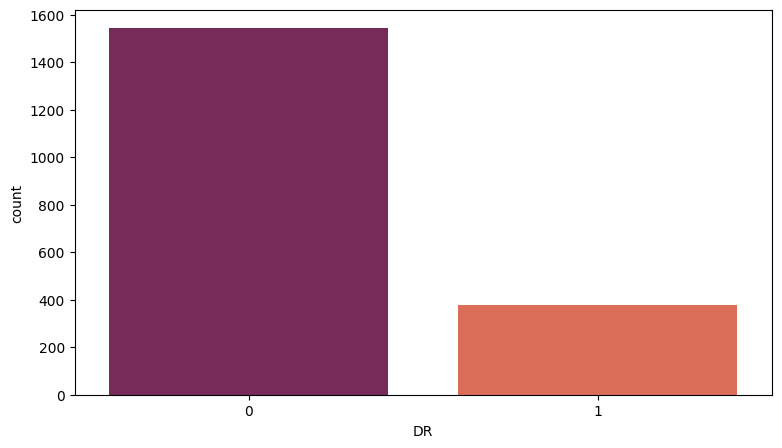

In [8]:
import seaborn as sns
# Check if 'labels' column exists in your DataFrame
if 'DR' in train_df.columns:
    # Display the number of pictures of each category
    vc = train_df['DR'].value_counts()
    plt.figure(figsize=(9, 5))
    sns.barplot(x=vc.index, y=vc, palette="rocket")
else:
    print("'DR' column not found in the DataFrame.")

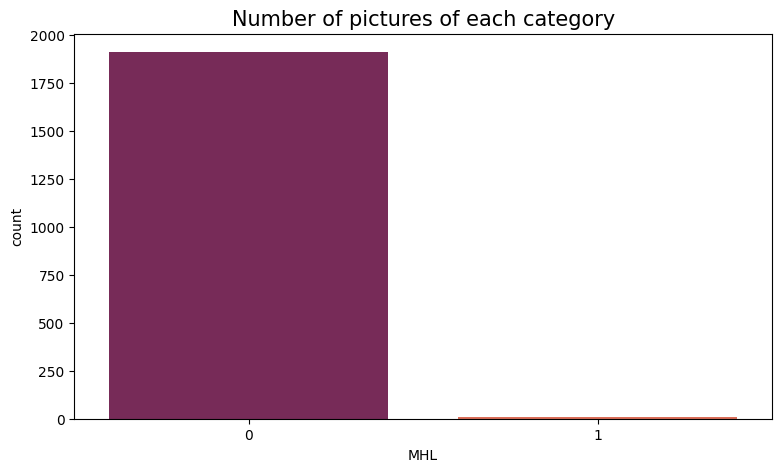

In [9]:
# Display the number of pictures of each category
vc = train_df['MHL'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [10]:
# calculate average weight men l coloumn kolaha
def weight_calc(col):
    total = len(train_df)
    weight = (1 / train_df[col].sum()) *  total / 2
    return weight

In [12]:

import keras.backend as K
gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss


In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rotation_range=90,
                                                                brightness_range=[0, 0.1])
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [15]:
train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col='img_path',
                                              y_col=Y_train,
                                              target_size=(150,150),
                                              class_mode='raw',
                                              batch_size=16,
                                              shuffle=True)

NameError: name 'Y_train' is not defined

# **MixUp**

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def mixup(x, y, alpha=0.2):
    batch_size = len(x)
    lam = np.random.beta(alpha, alpha, batch_size)
    x_mix = lam.reshape(-1, 1, 1, 1) * x + (1 - lam).reshape(-1, 1, 1, 1) * np.flip(x, axis=0)
    
    # Mixup for multi-class labels
    y_mix = lam.reshape(-1, 1) * y + (1 - lam).reshape(-1, 1) * np.flip(y, axis=0)
    
    return x_mix, y_mix

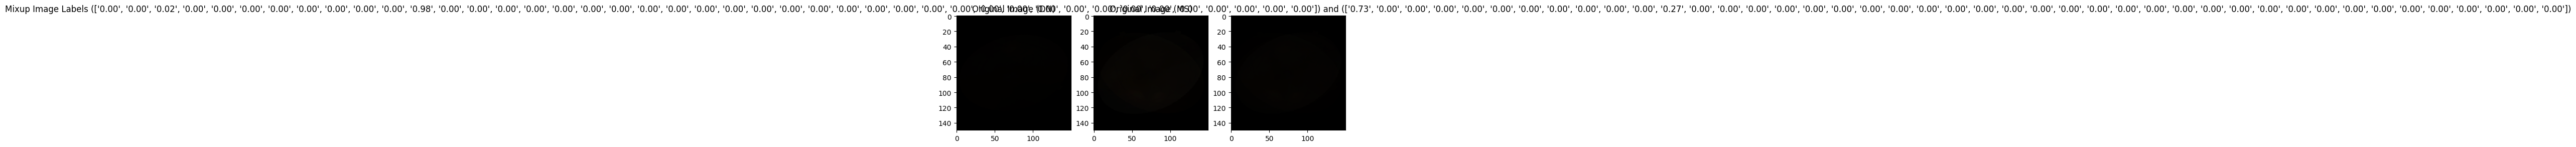

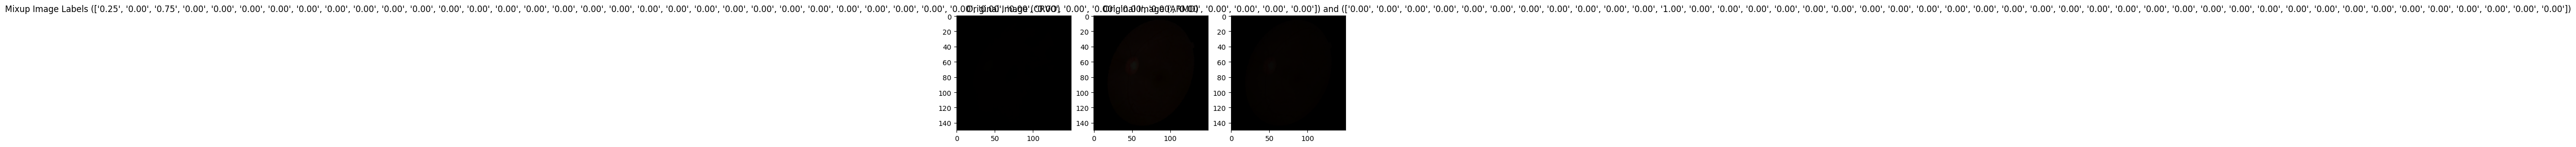

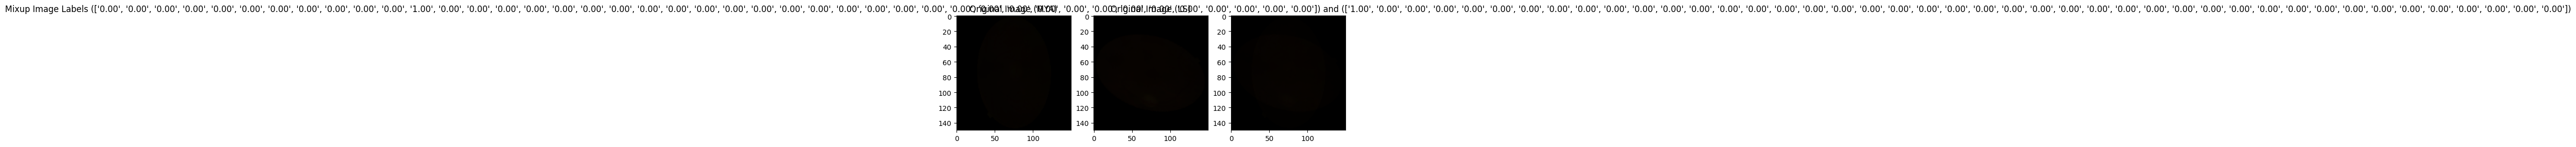

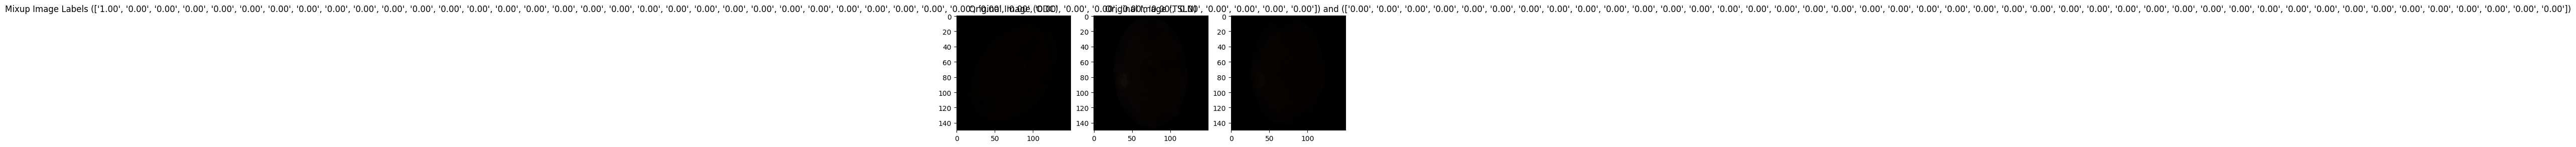

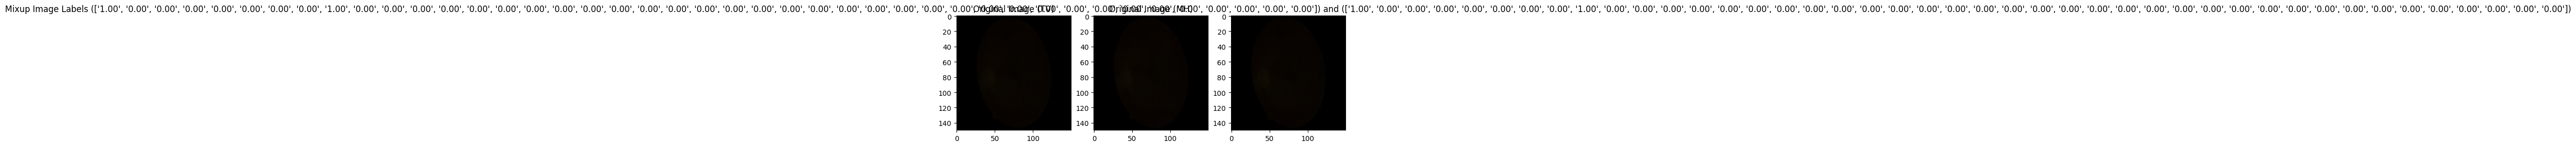

In [24]:
# Create Mixup data generator
def mixup_generator(train_gen, alpha=0.2):
    while True:
        x, y = next(train_gen)
        x_mix, y_mix = mixup(x, y, alpha=alpha)
        yield x_mix, y_mix

train_gen_mixup = mixup_generator(train_gen)

import numpy as np
import matplotlib.pyplot as plt

def plot_mixup_images(generator, num_samples=5):
    for _ in range(num_samples):
        x_mix, y_mix = next(generator)
        
        # Choose two random images from the batch
        idx1 = np.random.randint(len(x_mix))
        idx2 = np.random.randint(len(x_mix))
        
        # Plot the original images and the Mixup image
        plt.figure(figsize=(10, 8))
        
        plt.subplot(1, 3, 1)
        plt.imshow(x_mix[idx1])
        plt.title(f'Original Image ({Y_train[idx1]})')
        
        plt.subplot(1, 3, 2)
        plt.imshow(x_mix[idx2])
        plt.title(f'Original Image ({Y_train[idx2]})')
        
        plt.subplot(1, 3, 3)
        plt.imshow(x_mix[idx1] * 0.5 + x_mix[idx2] * 0.5)  # Mixup image
        
        # Format the labels as a list
        label1 = [f"{y:.2f}" for y in y_mix[idx1]]
        label2 = [f"{y:.2f}" for y in y_mix[idx2]]
        plt.title(f'Mixup Image Labels ({label1}) and ({label2})')
        
        plt.show()

# Plot Mixup images
plot_mixup_images(train_gen_mixup, num_samples=5)

In [25]:
val_gen = val_datagen.flow_from_dataframe(val_df,
                                          x_col='img_path',
                                          y_col=Y_val,
                                          target_size=(150,150),
                                          class_mode='raw',
                                          batch_size=8)

Found 640 validated image filenames.


In [26]:
test_gen = test_datagen.flow_from_dataframe(test_df,
                                            x_col='img_path',
                                            y_col=Y_test,
                                            target_size=(150,150),
                                            class_mode='raw')

Found 640 validated image filenames.


In [27]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input

In [28]:
pre_trained_model = DenseNet201(input_shape = (150,150, 3), 
                                include_top = False, 
                                weights = None)
# pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable = False
last_layer = pre_trained_model.get_layer('conv5_block32_concat')

last_output = last_layer.output

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

x = layers.Flatten()(last_output)
x = layers.Dropout(0.5)(x) 
x = layers.Dense(1024, activation='relu')(x)                 
x = layers.Dense (1, activation='sigmoid')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
es= EarlyStopping(monitor='val_accuracy',mode='max', patience=2, restore_best_weights = True)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1/conv[0][0]']         

In [31]:
history = model.fit(
            train_gen,
            validation_data = val_gen,
            steps_per_epoch=20,
            epochs =50,
            validation_steps=5,
            verbose = 1,
            callbacks=[es])

Epoch 1/50
20/20 [==============================] - 83s 3s/step - loss: 0.6600 - accuracy: 0.9366 - val_loss: 0.1980 - val_accuracy: 0.9773
Epoch 2/50
20/20 [==============================] - 60s 3s/step - loss: 0.5935 - accuracy: 0.9754 - val_loss: 0.1298 - val_accuracy: 0.9727
Epoch 3/50
20/20 [==============================] - 56s 3s/step - loss: 0.5314 - accuracy: 0.9757 - val_loss: 0.2053 - val_accuracy: 0.9698


In [32]:
results = model.evaluate(test_gen)

20/20 [==============================] - 104s 5s/step - loss: 0.2170 - accuracy: 0.9757


In [33]:
import tensorflow as tf
from IPython.display import display, Markdown
# Using the `printmd` function to display formatted text
display(Markdown("## Test Loss: {:.5f}".format(results[0])))
display(Markdown("## Accuracy on the test set: {:.2f}%".format(results[1] * 100)))
'''
 before focal loss 
 loss: 0.5048 - accuracy: 0.9747
 
 focal loss 0.2
 loss: 0.2170 - accuracy: 0.9757

'''

## Test Loss: 0.21699

## Accuracy on the test set: 97.57%

'\n before focal loss \n loss: 0.5048 - accuracy: 0.9747\n \n focal loss 0.2\n loss: 0.2170 - accuracy: 0.9757\n\n'

In [34]:
diseased_labels = []
for i in test_gen.labels:
    if(i.any() == 1):
        diseased_labels.append(1)
    else:
        diseased_labels.append(0)

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

predictions = model.predict(test_gen)
transfer_thres = np.average(predictions)
y_pred = (predictions > transfer_thres)*1

20/20 [==============================] - 89s 4s/step


Transfer model confusion matrix


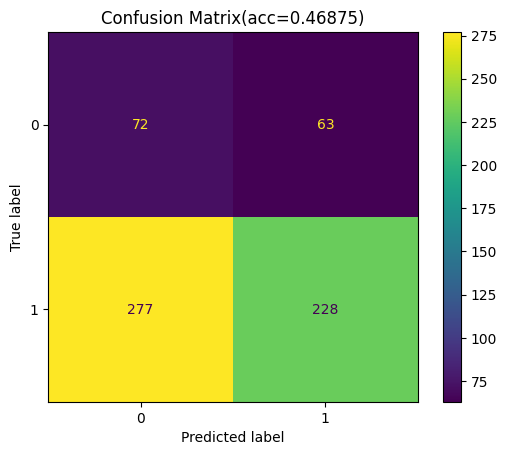

In [36]:
print("Transfer model confusion matrix")
transfer_acc = accuracy_score(diseased_labels, y_pred)
transfer_cm = confusion_matrix(diseased_labels, y_pred)
transfer_disp = ConfusionMatrixDisplay(transfer_cm)
transfer_disp.plot()
plt.title(f'Confusion Matrix(acc={transfer_acc})')
plt.show()

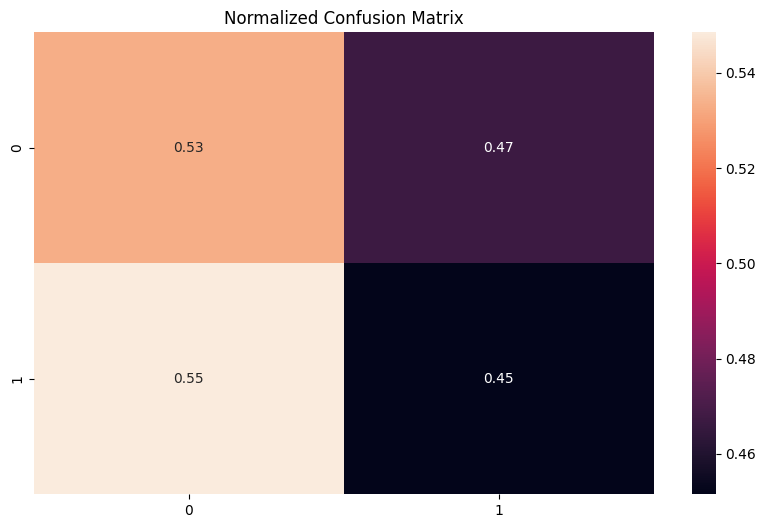

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(diseased_labels, y_pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(diseased_labels)), yticklabels = sorted(set(diseased_labels)))
plt.title('Normalized Confusion Matrix')
plt.show()

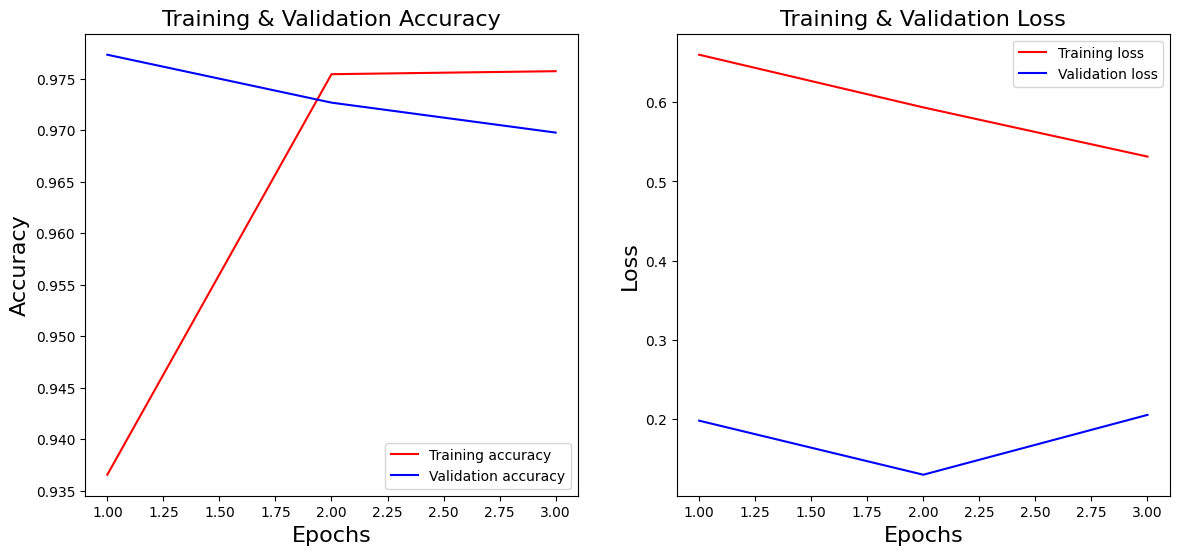

In [40]:
import matplotlib.pyplot as plt
 
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [42]:
from sklearn.metrics import classification_report
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(diseased_labels, y_pred),5))
print('Precision:', np.round(metrics.precision_score(diseased_labels, y_pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(diseased_labels,y_pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(diseased_labels, y_pred, average='weighted'),5))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(diseased_labels, y_pred),5))
print(classification_report(diseased_labels, y_pred))

Accuracy: 0.46875
Precision: 0.66175
Recall: 0.46875
F1 Score: 0.51478
Cohen Kappa Score: -0.0096
              precision    recall  f1-score   support

           0       0.21      0.53      0.30       135
           1       0.78      0.45      0.57       505

    accuracy                           0.47       640
   macro avg       0.49      0.49      0.44       640
weighted avg       0.66      0.47      0.51       640



# **ROC curve**

In [43]:
from sklearn.metrics import roc_curve, auc

# After model training, predict probabilities for each class
y_pred_probs = model.predict(test_gen)

20/20 [==============================] - 87s 4s/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ran

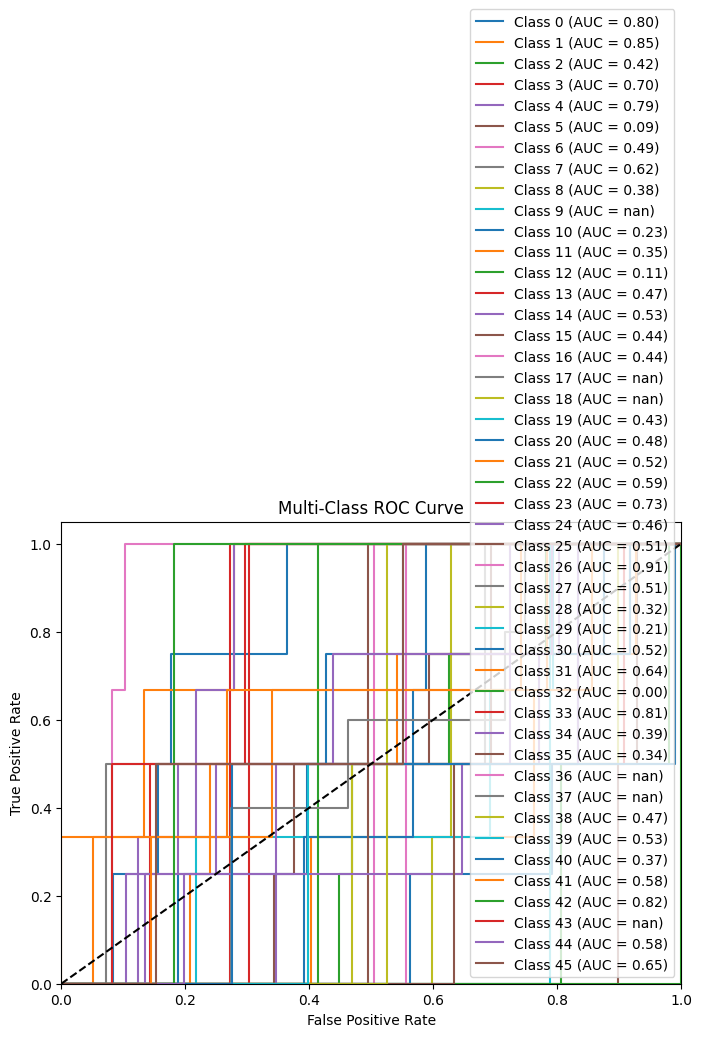

In [46]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a model that predicts probabilities for each class
# Replace y_pred_probs with your model's predicted probabilities
# y_pred_probs should be a 2D array with shape (num_samples, num_classes)
# Replace test_labels with your true labels (ground truth) for each sample
# test_labels should be an array with shape (num_samples,)
y_pred_probs = np.random.rand(100, 46)  # Example random predicted probabilities
test_labels = np.random.randint(46, size=100)  # Example random true labels

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = y_pred_probs.shape[1]  # Number of classes

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

# **gradCam**

In [47]:
!pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00


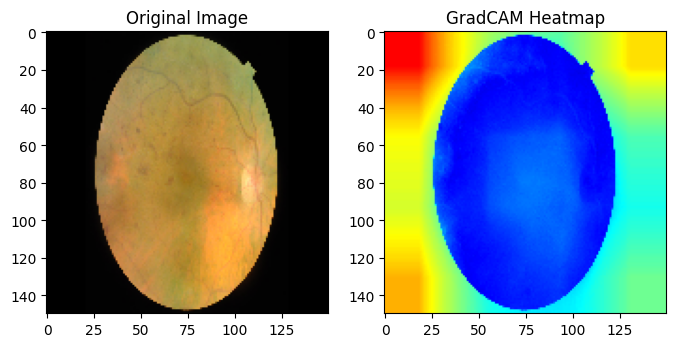

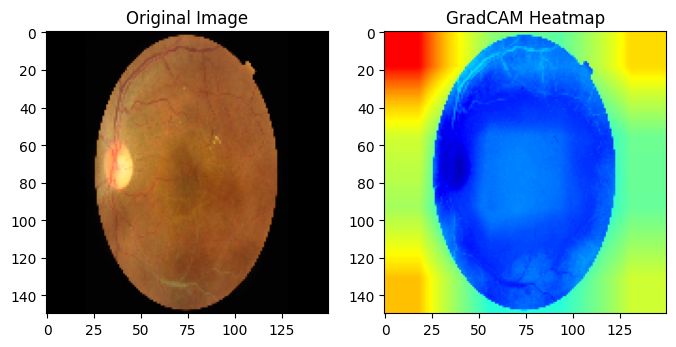

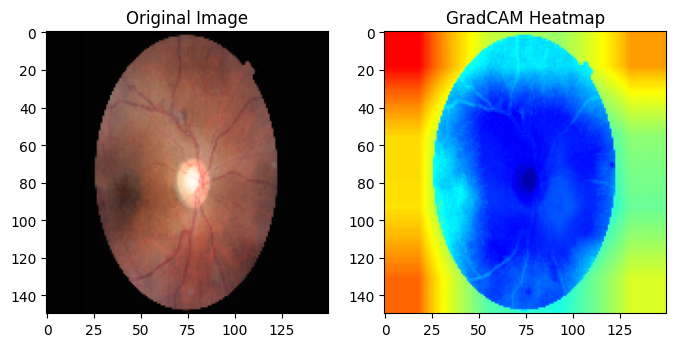

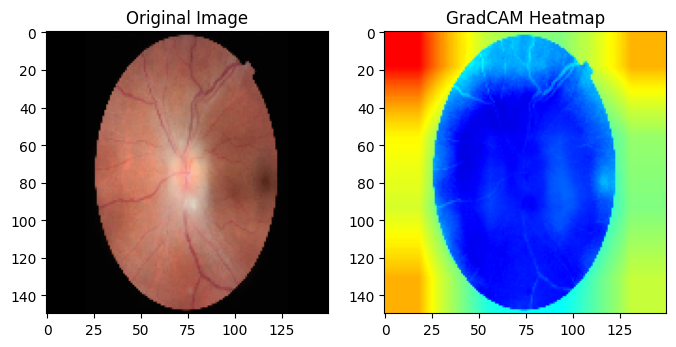

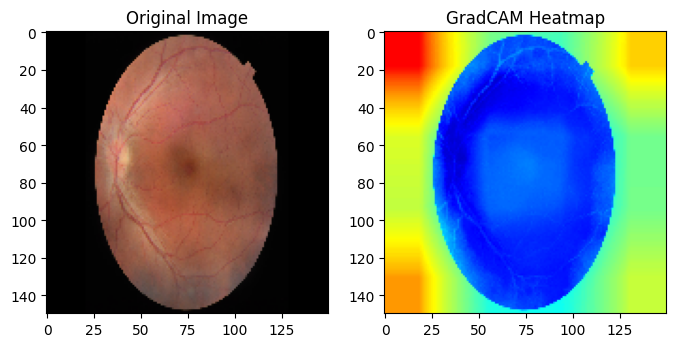

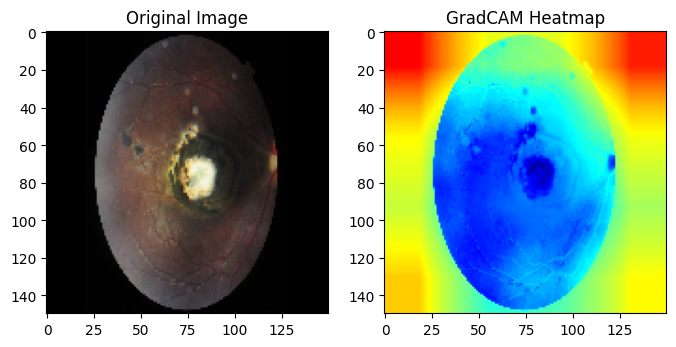

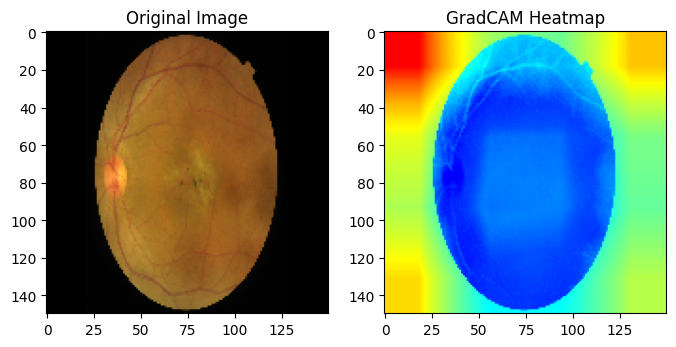

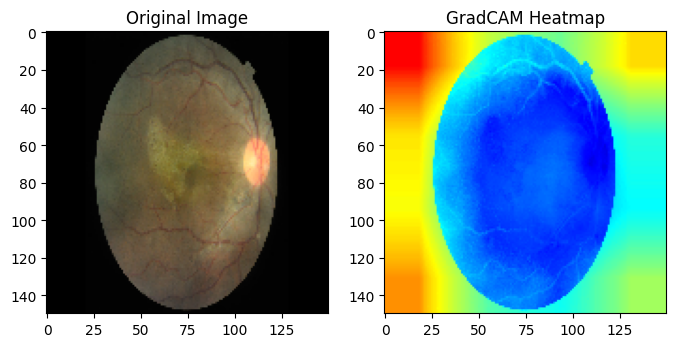

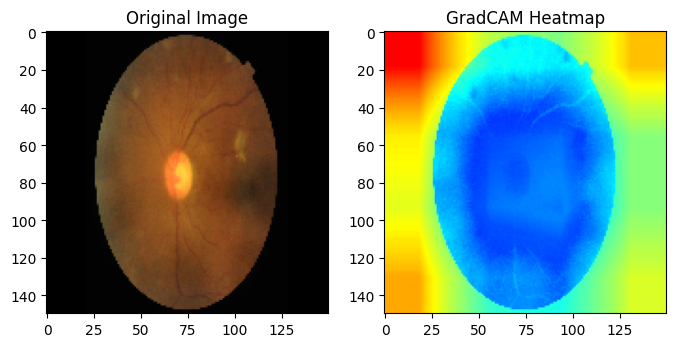

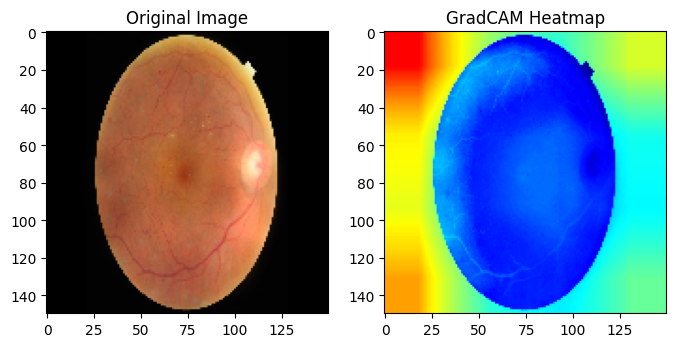

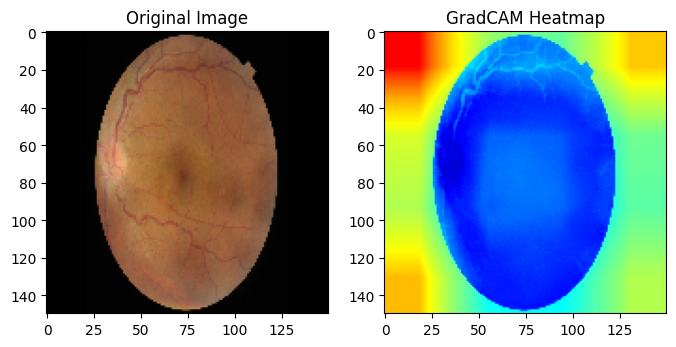

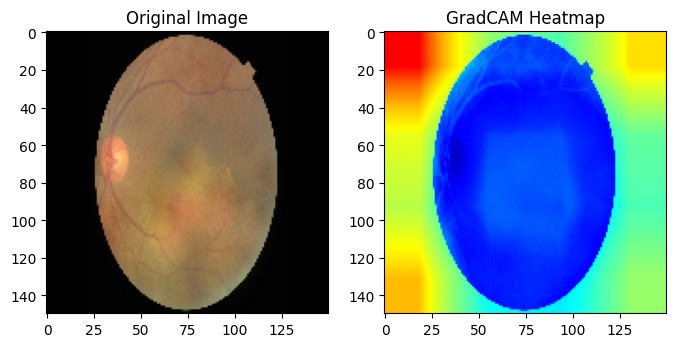

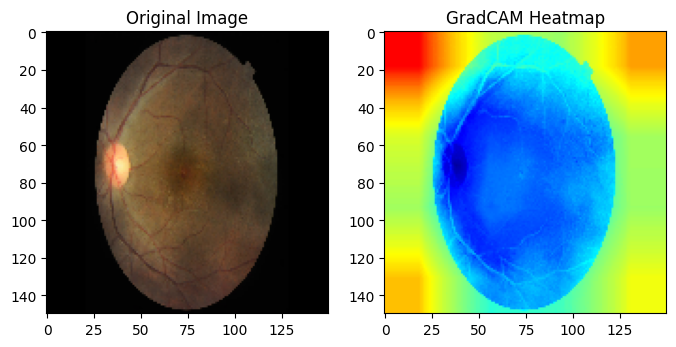

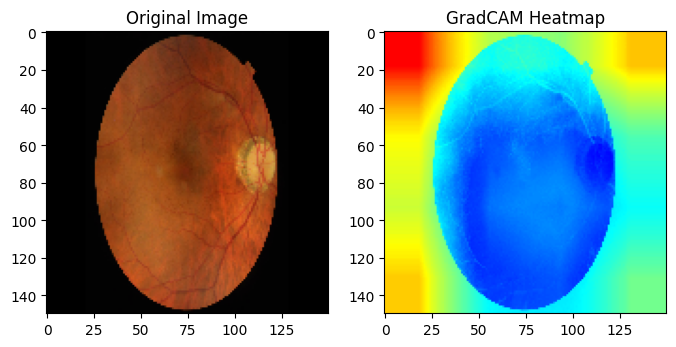

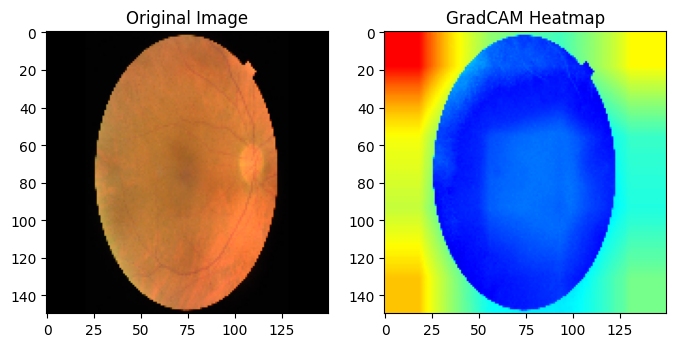

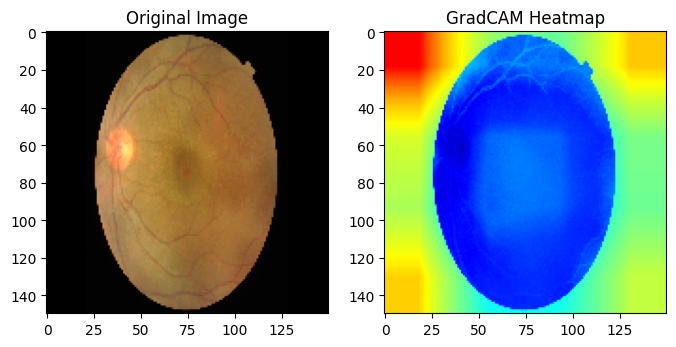

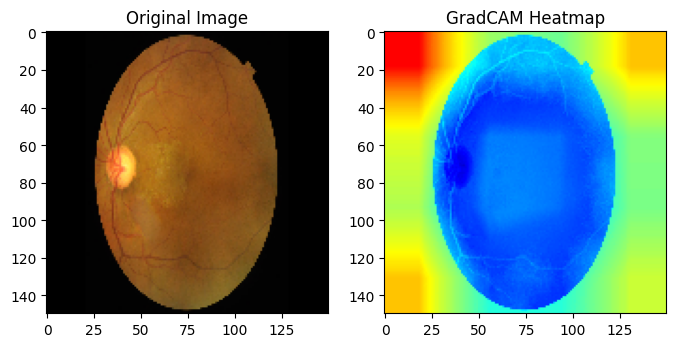

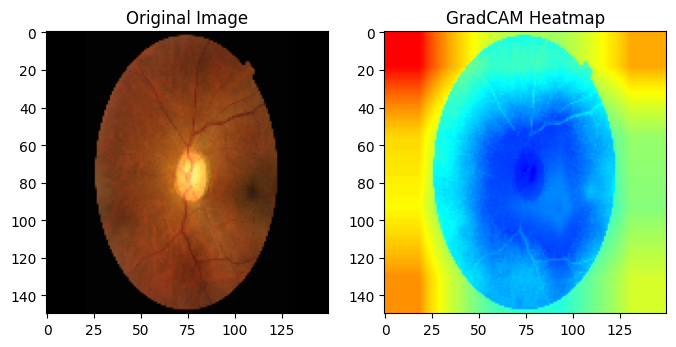

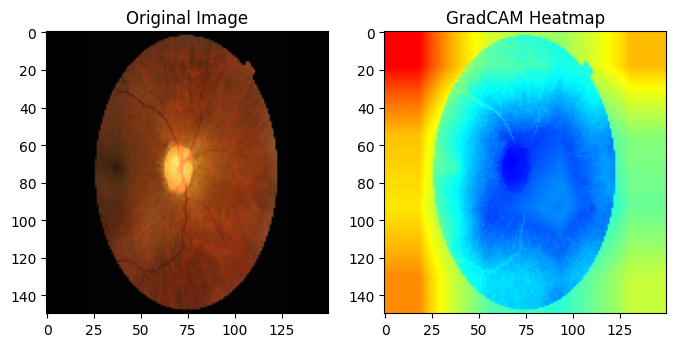

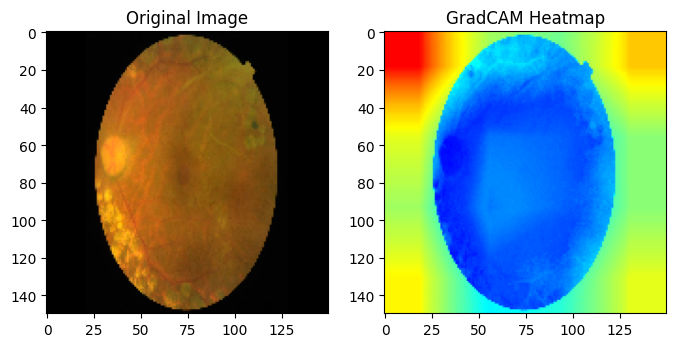

In [48]:
from tf_explain.core.grad_cam import GradCAM
import cv2

# Choose an image index for GradCAM visualization
image_index = np.random.rand(20)  # Change this to the index of the image you want to visualize

# Load the image using tf.keras
for image_index in range(20):
    image_path = test_df['img_path'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)


# Preprocess the image
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

# Create GradCAM explainer
    explainer = GradCAM()

# Choose the layer for visualization (e.g., the last convolutional layer)
    layer_name = "conv5_block32_concat"

# Explain the model's prediction
    grid = explainer.explain(validation_data=(img_array, None), model=model, class_index=0, layer_name=layer_name)

# Plot the original image and GradCAM heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grid), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title('GradCAM Heatmap')
    plt.show()
    image_index=+1

In [50]:
model.save('DenseNet201_new50.h5')